In [31]:
# For colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Notebook Summary

This notebook consists of three major portions:

1. In first portion, we start with analyzing our data. This portion includes:

    *   Snapshot of source from where we downloaded the data into our working directory.

    *   Observing class imbalance by analyzing the distribution of class frequencies within a dataset.

    *   Visualizations of normal and then augmented training data
   
    *   Image preprocessing, including normalization of image data and one hot encoding of target variable as it is a multiclass problem.

2. In second portion we tried out different approaches to obtain a classifier with optimal results, we tried:

    *   Self designed Convolutional Neural Network

    *   Self designed Convolutional Neural Network with Augmented training data (data augmentation induces variations in dataset, hence better generalization)

    *   Transfer Learning approach (using VGG network)

3. Last portion we evaluate the performances of three approaches applied above using confusion matrix and classification reports, we then saved the model with best performance (for our Web app), which was "Self designed CNN with Augmented training data"








In [33]:
# Import libraries
import os,cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint 
from keras.layers import MaxPooling2D
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import LSTM
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Activation
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, balanced_accuracy_score, roc_curve
import seaborn as sns
import pickle

# 1. Load, Analyze and Preprocess Data

## 1.1. Loading Data

We have used "https://zenodo.org/record/6496656#.Y_q_XYDP1uQ" mentioned on "https://medmnist.com/" to download the breast and blood cancer dataset in our working directory. You can see it in the highlighted area in the snapshot of website.

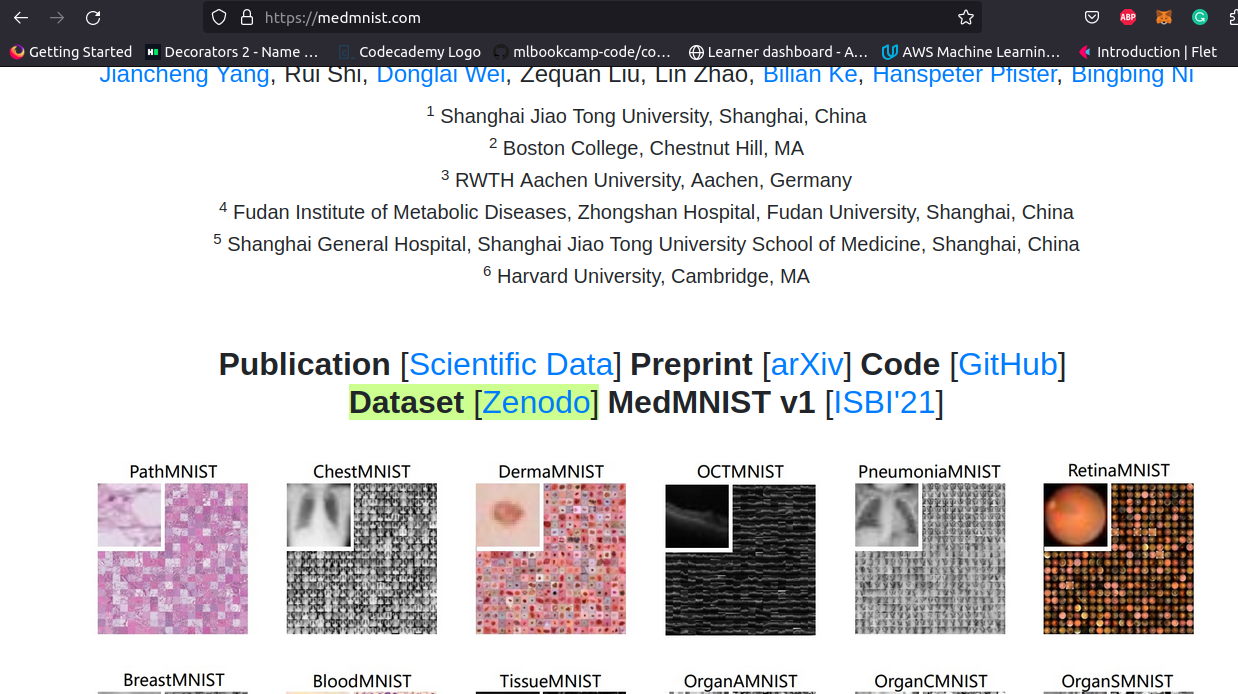

In [34]:
#For google colab

X_train = np.load("/content/drive/MyDrive/Project2/bloodmnist/data/train_images.npy")
X_test = np.load("/content/drive/MyDrive/Project2/bloodmnist/data/test_images.npy")
X_val = np.load("/content/drive/MyDrive/Project2/bloodmnist/data/val_images.npy")

y_train = np.load("/content/drive/MyDrive/Project2/bloodmnist/data/train_labels.npy")
y_test = np.load("/content/drive/MyDrive/Project2/bloodmnist/data/test_labels.npy")
y_val = np.load("/content/drive/MyDrive/Project2/bloodmnist/data/val_labels.npy")

# #For vscode


# X_train = np.load("data/train_images.npy")
# X_test = np.load("data/test_images.npy")
# X_val = np.load("data/val_images.npy")

# y_train = np.load("data/train_labels.npy")
# y_test = np.load("data/test_labels.npy")
# y_val = np.load("data/val_labels.npy")

In [35]:
print("Training set dimensions:\n")
print(X_train.shape)
print(y_train.shape)

print("\nTesting set dimensions:\n")
print(X_test.shape)
print(y_test.shape)

print("\nValidation set dimensions:\n")
print(X_val.shape)
print(y_val.shape)

Training set dimensions:

(11959, 28, 28, 3)
(11959, 1)

Testing set dimensions:

(3421, 28, 28, 3)
(3421, 1)

Validation set dimensions:

(1712, 28, 28, 3)
(1712, 1)


We have 11,959,3421 and 1712 images in our training, testing and validation sets respectively.
Each image has three channels (R,G,B) of 28x28 dimensions each. 
The size and dimension of dataset matches to that given on "https://medmnist.com/", hence we can say that we have successfully loaded the complete dataset and no data is missing.

Let us now futher analyse our image dataset by combining all training, testing and validation samples.

## 1.2. Analyzing the Data

In [8]:
#Creating a function for counting and printing class-wise frequency in dataset

def class_frequency(y,datasetname):

  unique, counts = np.unique(y, return_counts=True)

  print(f"Calculating class wise frequency in {datasetname} dataset!\n")

  for i in range(len(np.unique(y))):

    print(f'{unique[i]} occured: {counts[i]} times: {counts[i]*100/sum(counts):.2f}% of data\n')

In [9]:
y = np.vstack((y_train, y_val, y_test))

class_frequency(y,"complete")

Calculating class wise frequency in complete dataset!

0 occured: 1218 times: 7.13% of data

1 occured: 3117 times: 18.24% of data

2 occured: 1551 times: 9.07% of data

3 occured: 2895 times: 16.94% of data

4 occured: 1214 times: 7.10% of data

5 occured: 1420 times: 8.31% of data

6 occured: 3329 times: 19.48% of data

7 occured: 2348 times: 13.74% of data



In [10]:
class_frequency(y_train,"Training")

Calculating class wise frequency in Training dataset!

0 occured: 852 times: 7.12% of data

1 occured: 2181 times: 18.24% of data

2 occured: 1085 times: 9.07% of data

3 occured: 2026 times: 16.94% of data

4 occured: 849 times: 7.10% of data

5 occured: 993 times: 8.30% of data

6 occured: 2330 times: 19.48% of data

7 occured: 1643 times: 13.74% of data



In [11]:
class_frequency(y_val,"Validation")

Calculating class wise frequency in Validation dataset!

0 occured: 122 times: 7.13% of data

1 occured: 312 times: 18.22% of data

2 occured: 155 times: 9.05% of data

3 occured: 290 times: 16.94% of data

4 occured: 122 times: 7.13% of data

5 occured: 143 times: 8.35% of data

6 occured: 333 times: 19.45% of data

7 occured: 235 times: 13.73% of data



In [12]:
class_frequency(y_train, "Training")

Calculating class wise frequency in Training dataset!

0 occured: 852 times: 7.12% of data

1 occured: 2181 times: 18.24% of data

2 occured: 1085 times: 9.07% of data

3 occured: 2026 times: 16.94% of data

4 occured: 849 times: 7.10% of data

5 occured: 993 times: 8.30% of data

6 occured: 2330 times: 19.48% of data

7 occured: 1643 times: 13.74% of data



The analysis of the % distribution of data in the training, testing, and validation samples indicates that the data is evenly distributed across all three samples, relative to its occurrence in the complete dataset.

If we try to balance classes in training dataset, it will result in class imbalance in Training and Validation sets respectively.

## 1.3. Visualizing few training instances

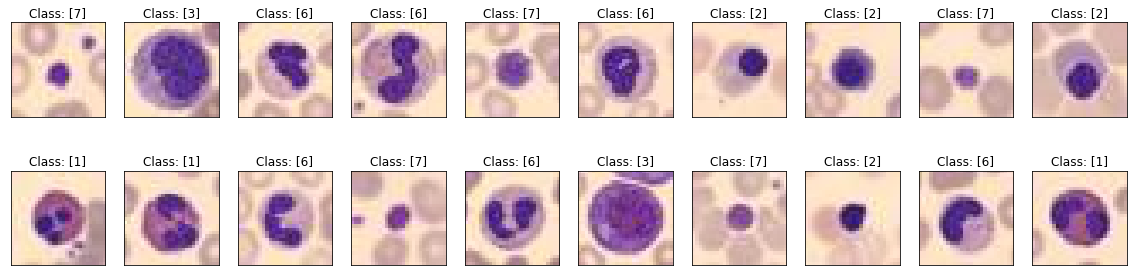

In [13]:
fig = plt.figure(figsize=(20,5))

for i in range(20):
    ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[i]))
    ax.set_title(f'Class: {y_train[i]}')

## 1.4. Augmented Image Generator

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.11,  # randomly shift images horizontally (11% of total width)
    height_shift_range=0.13,  # randomly shift images vertically (13% of total height)
    horizontal_flip=True) # randomly flip images horizontally


## 1.5. Visualizing Augmented Images

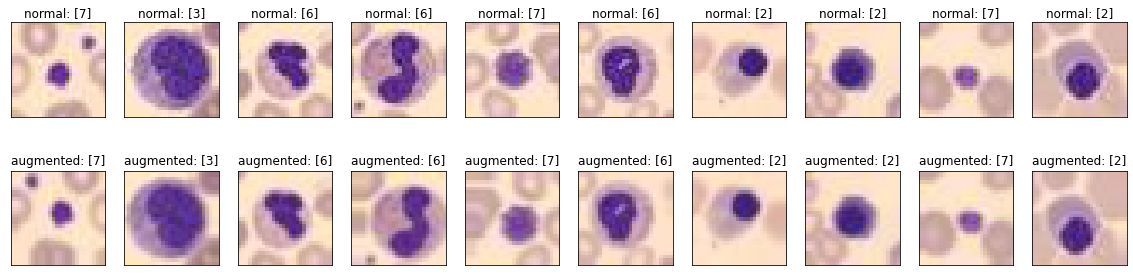

In [15]:
#plot augmented images!

fig = plt.figure(figsize=(20,5))

# display normal images
for i in range(10):
    ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[i]))
    ax.set_title(f'normal: {y_train[i]}')

# display augmented images
for i in range(10):
    # apply data augmentation to the ith image
    img = X_train[i]
    img = datagen_train.random_transform(img)
    
    # display the augmented image
    ax = fig.add_subplot(2, 10, i + 11, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img))
    ax.set_title(f'augmented: {y_train[i]}')

We can observe slight variations that we have added in our image set, these variations should help us achieve more generalized model.

## 1.6. One hot encoding

This is one of most crucial steps in Multiclass Machine Learning/Deep Learning problems. 
One hot coding is important because without it the network might incorrectly assume that the categories have a natural order or numerical relationship, leading to incorrect predictions.


In [16]:
# Viewing target instances before one hot encoding

y_train[0:2]

array([[7],
       [3]], dtype=uint8)

In [17]:
# One hot encode the labels

num_classes = len(np.unique(y_train))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

In [18]:
# Target after one hot encoding

y_train[0:2]

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [19]:
#We have encoded our output now!

## 1.7. Normalize the Image

In [20]:
# It is recommended practice to rescale images from (0-255) scale to (0,1) scale, 
# Lowering down the scale results in better performance in terms of weights assignment during the learning process

X_train = X_train/255.0
X_test = X_test/255.0
X_val = X_val/255.0

Now that we have loaded our image data and preprocessed it, we can now design our Convolutional Neural Network Architecture and try for different sets of Convolutional and dense layers, with different parameters and check for what number of layers and which parameters result in better validation and testing accuracies.

# 2. SELF DESIGNED CONVOLUTIONAL NEURAL NETWORK ARCHITECTURE

## 2.1. Model Architecture

In [21]:
#Creating a function to generate model architecture as we intend to use same architecture two times in our notebook

def create_architecture():


  """
  Creates a convolutional neural network architecture using the Keras Sequential API.

  The model contains 4 convolutional layers, each followed by a max pooling layer, and 4 dense layers.

  """

  #STRINGING MODEL SEQUENTIALLY, WITH 4 CONVOLUTION LAYERS & 4 DENSE LAYERS  
  model = Sequential([
    
      #Convolution Layers along with max pooling
    
      # Defining a convolutional layer with 10 filters of size 2x2
      # Padding is set to 'same', which means output feature map has same dimensions as input image
      # Activation function used is ReLU
      # Input shape is (28, 28, 3), meaning input is an RGB image of size 28x28
      Conv2D(10,2,padding='same',activation='relu',input_shape=(28, 28, 3)),
    
      # Defining a max pooling layer with a pooling window of 2x2 and stride of 2x2
      # This will reduce the dimensions of the output feature map from the previous Conv2D layer
      MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
      #Let's add more convolutional and maxpool layers (conv2D is used because we have 2D images)
      Conv2D(30,2,padding='same',activation='relu'),
      MaxPool2D(pool_size=(2,2),strides=(2,2)),   
    
      Conv2D(60,2,padding='same',activation='relu'),
      MaxPool2D(pool_size=(2,2),strides=(2,2)),

      Conv2D(180,2,padding='same',activation='relu'),
      MaxPool2D(pool_size=(2,2),strides=(2,2)),   
    

      #flatenning all the matrices into an array
    
      Flatten(),
    
      #passing the flattened array to 4 Dense layers
    
      Dense(120, activation = 'relu'),
      Dense(65, activation = 'relu'),
      Dense(35, activation = 'relu'),

      #Prediction layer contains 8 neurons here, each neuron will display output "probability" of input respective to each class
      #softmax activation is used for multiclass problems
      Dense(8, activation = 'softmax')
  ])

  learning_rate=0.001
  model.compile(loss=categorical_crossentropy,optimizer=Adam(learning_rate),metrics=['accuracy'])


  return model

In [22]:
#Creating model_self (model with self built CNN) object
model_self = create_architecture()

#Model Summary
model_self.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 10)        130       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 30)        1230      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 30)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 60)          7260      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 60)         0

## 2.2. Training Model

In [ ]:
# train the model
seed = 1

#setting seed to ensure code's reproducibility
tf.random.set_seed(seed)
random.seed(seed)

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Project2/bloodmnist/self_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

# checkpointer = ModelCheckpoint(filepath='self_model.weights.best.hdf5', verbose=1, 
#                                save_best_only=True)

model_self.fit(X_train, y_train, epochs=90, validation_data=(X_val, y_val), callbacks=[checkpointer])

Epoch 1/90
374/374 [==============================] - ETA: 0s - loss: 1.3456 - accuracy: 0.4834
Epoch 1: val_loss improved from inf to 1.08934, saving model to /content/drive/MyDrive/Project2/bloodmnist/self_model.weights.best.hdf5
374/374 [==============================] - 4s 7ms/step - loss: 1.3456 - accuracy: 0.4834 - val_loss: 1.0893 - val_accuracy: 0.5794
Epoch 2/90
374/374 [==============================] - ETA: 0s - loss: 0.9010 - accuracy: 0.6451
Epoch 2: val_loss improved from 1.08934 to 0.73299, saving model to /content/drive/MyDrive/Project2/bloodmnist/self_model.weights.best.hdf5
374/374 [==============================] - 2s 7ms/step - loss: 0.9010 - accuracy: 0.6451 - val_loss: 0.7330 - val_accuracy: 0.7214
Epoch 3/90
367/374 [============================>.] - ETA: 0s - loss: 0.7324 - accuracy: 0.7176
Epoch 3: val_loss improved from 0.73299 to 0.61977, saving model to /content/drive/MyDrive/Project2/bloodmnist/self_model.weights.best.hdf5
374/374 [=========================

## 2.3. Evaluating Model on Testing data

Please note that this is just basic evaluation where we are just calculating testing accuracy, which is not reccomended practice.


We have a separate section "4" for testing model intensively before taking the best model to production.

In [ ]:
# load the weights that yielded the best validation accuracy
# model_self.load_weights('/content/drive/MyDrive/Project2/bloodmnist/self_model.weights.best.hdf5')

model_self.load_weights('self_model.weights.best.hdf5')

score = model_self.evaluate(X_test, y_test, verbose=1)
print(f'\nTest accuracy: {score[1]:.4f}')

107/107 [==============================] - 1s 5ms/step - loss: 0.2211 - accuracy: 0.9258

Test accuracy: 0.9258


# 3. Self Designed Neural Network Architecture with **Augmented** Training Data

This model differs from the model above as we are now including the augmented training instances, this should result in better generalization, hence better validation and testing performance, due to induced variations in training instances.

## 3.1. Model Architecture

We will use same architecture we made in 2.1.

In [ ]:
model_augmented = create_architecture()
model_augmented.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 10)        130       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 30)        1230      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 7, 7, 30)         0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 60)          7260      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 3, 3, 60)        

## 3.2. Training Model

In [ ]:
# train the model
tf.random.set_seed(1) 

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Project2/bloodmnist/aug_model.weights.best.hdf5', save_best_only=True, verbose=1)

# checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', save_best_only=True, verbose=1)

#datagen_train object used here was created in the start to ensue variations in our training dataset, these variations will lead to better generalization
model_augmented.fit(datagen_train.flow(X_train, y_train),epochs=100,validation_data=(X_val, y_val),callbacks=[checkpointer])

Epoch 1/100
372/374 [============================>.] - ETA: 0s - loss: 1.4029 - accuracy: 0.4529
Epoch 1: val_loss improved from inf to 1.15366, saving model to /content/drive/MyDrive/Project2/bloodmnist/aug_model.weights.best.hdf5
374/374 [==============================] - 10s 23ms/step - loss: 1.4013 - accuracy: 0.4531 - val_loss: 1.1537 - val_accuracy: 0.5619
Epoch 2/100
374/374 [==============================] - ETA: 0s - loss: 0.9347 - accuracy: 0.6455
Epoch 2: val_loss improved from 1.15366 to 0.65648, saving model to /content/drive/MyDrive/Project2/bloodmnist/aug_model.weights.best.hdf5
374/374 [==============================] - 9s 23ms/step - loss: 0.9347 - accuracy: 0.6455 - val_loss: 0.6565 - val_accuracy: 0.7535
Epoch 3/100
372/374 [============================>.] - ETA: 0s - loss: 0.7009 - accuracy: 0.7302
Epoch 3: val_loss improved from 0.65648 to 0.63727, saving model to /content/drive/MyDrive/Project2/bloodmnist/aug_model.weights.best.hdf5
374/374 [======================

## 3.3. Evaluating Model on Testing dataset

In [ ]:
# load the weights that yielded the best validation accuracy (google collab)
# model_augmented.load_weights('/content/drive/MyDrive/Project2/bloodmnist/aug_model.weights.best.hdf5')

# load from working directory
model_augmented.load_weights('aug_model.weights.best.hdf5')


score = model_augmented.evaluate(X_test, y_test)
print(f'\nTest accuracy: {score[1]:.4f}')

107/107 [==============================] - 1s 5ms/step - loss: 0.1777 - accuracy: 0.9445

Test accuracy: 0.9445


# 4. Transfer Learning 

Transfer learning involves using a pre-trained neural network and fine-tuning it on a new dataset.

We will be using VGG16 which is a popular architecture used in transfer learning, and it is quite suitable for feature extraction from image-based datasets.

The VGG16 model achieved a test accuracy of 92.7% in ImageNet (a dataset containing more than 14 million hand labelled training images across 1000 object classes).

[1] source: https://datagen.tech/guides/computer-vision/vgg16/

We will not train the layers on vgg16, and will only update the weights of new dense layers. 

## 4.1. Data Preprocessing

For VGG16 the shape of input should be 224,224,3 (width,height,channels(RGB)), so resizing the image to 224,224,3 is the most crucial step to begin with.

In the code block below, we will first load the image data, then configure it to 228,228,3 as per the input requirements of VGG16.

Please note that due to computational constraints we were not able to fine tune our transfer learning model to complete data, so we have taken almost 50% of our dataset. This also resulted in suboptimal results. So it is important to mention that we have used the transfer learning approach for demonstration purpose only.

In [23]:
# Load the train, test, and validation images (Google collab)
X_train_vgg = np.load("/content/drive/MyDrive/Project2/bloodmnist/data/train_images.npy")
X_test_vgg = np.load("/content/drive/MyDrive/Project2/bloodmnist/data/test_images.npy")
X_val_vgg = np.load("/content/drive/MyDrive/Project2/bloodmnist/data/val_images.npy")

# # from local directory
# X_train_vgg = np.load("data/train_images.npy")
# X_test_vgg = np.load("data/test_images.npy")
# X_val_vgg = np.load("data/val_images.npy")


# Resize the images to a size of 228x228 pixels 
# Please note that we are not rescaling images because of computational constraints
# We are also unable to use all images as for the same reason mentioned above
# Nevertheless the transfer learning approach used here is solely for our understanding purposes

X_train_ = np.array([cv2.resize(img, (224, 224)) for img in X_train_vgg[:5000]])
X_test_ = np.array([cv2.resize(img, (224, 224)) for img in X_test_vgg[:2500]])
X_val_ = np.array([cv2.resize(img, (224, 224)) for img in X_val_vgg[:1500]])

# Print the shape of the resized images
print(X_train_.shape)

y_train_ = y_train[:5000]
y_test_ = y_test[:2500]
y_val_ = y_val[:1500]

print(y_train_.shape)


(5000, 224, 224, 3)
(5000, 8)


## 4.2. Model Architecture

In [24]:
from keras.applications import VGG16

# "include_top=False" means only the convolutional layers of the pre-trained model are kept
vgg=VGG16(include_top=False, input_shape=(224,224,3))

# vgg.trainable = False ensures that we will not update the weights on vgg16 during training process
vgg.trainable = False
flatten=Flatten()

#We will use 3 dense layers on vgg convolution layers
layer_1=Dense(65, activation='relu')
layer_2=Dense(35,activation='relu')
prediction_layer=Dense(8,activation='softmax')

58889256/58889256 [==============================] - 0s 0us/step


In [25]:
model_vgg=Sequential([
    
    vgg,
    flatten,
    layer_1,
    layer_2,
    prediction_layer

])

learning_rate=0.001
model_vgg.compile(loss=categorical_crossentropy,optimizer=Adam(learning_rate),metrics=['accuracy'])

model_vgg.summary(expand_nested=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 224, 224, 3)]     0         |
|                                                               |
| block1_conv1 (Conv2D)     (None, 224, 224, 64)      1792      |
|                                                               |
| block1_conv2 (Conv2D)     (None, 224, 224, 64)      36928     |
|                                                               |
| block1_pool (MaxPooling2D)  (None, 112, 112, 64)    0         |
|                                                               |
| block2_conv1 (Conv2D)     (None, 112, 112, 128)     73856     |
|                                                               |
| block2_conv2 (Conv2D)     (None, 112, 112, 128)     

## 4.3. Model Training

In [26]:
# train the model
seed = 1

#setting seed to ensure code's reproducibility
tf.random.set_seed(seed)
random.seed(seed)

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Project2/bloodmnist/vgg_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

# checkpointer = ModelCheckpoint(filepath='vgg_model.weights.best.hdf5', verbose=1, 
#                                save_best_only=True)

model_vgg.fit(X_train_, y_train_, epochs=40, validation_data=(X_val_, y_val_), callbacks=[checkpointer])

Epoch 1/40
157/157 [==============================] - ETA: 0s - loss: 2.9704 - accuracy: 0.6542
Epoch 1: val_loss improved from inf to 1.51394, saving model to /content/drive/MyDrive/Project2/bloodmnist/vgg_model.weights.best.hdf5
157/157 [==============================] - 43s 205ms/step - loss: 2.9704 - accuracy: 0.6542 - val_loss: 1.5139 - val_accuracy: 0.6973
Epoch 2/40
157/157 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.8600
Epoch 2: val_loss improved from 1.51394 to 1.30863, saving model to /content/drive/MyDrive/Project2/bloodmnist/vgg_model.weights.best.hdf5
157/157 [==============================] - 31s 195ms/step - loss: 0.5277 - accuracy: 0.8600 - val_loss: 1.3086 - val_accuracy: 0.7580
Epoch 3/40
157/157 [==============================] - ETA: 0s - loss: 0.3774 - accuracy: 0.9110
Epoch 3: val_loss improved from 1.30863 to 0.82964, saving model to /content/drive/MyDrive/Project2/bloodmnist/vgg_model.weights.best.hdf5
157/157 [======================

## 4.4. Model Evaluation

In [27]:
# load the weights that yielded the best validation accuracy
model_vgg.load_weights('/content/drive/MyDrive/Project2/bloodmnist/vgg_model.weights.best.hdf5')

# # from local directory
# model_vgg.load_weights('vgg_model.weights.best.hdf5')

score = model_vgg.evaluate(X_test_, y_test_, verbose=1)
print(f'\nTest accuracy: {score[1]:.4f}')

79/79 [==============================] - 10s 126ms/step - loss: 0.8871 - accuracy: 0.8224

Test accuracy: 0.8224


# 5. Evaluating all Models

We need to evaluate models now in order to choose best model for deployment.

Let us first create the function to plot confusion matrix which is an important metric to gauge the performance of classification algorithm

In [28]:
def plot_cnf_matrix(y_test, y_pred, title):

    """
    Generate and plot a confusion matrix based on the true labels `y_test` and predicted labels `y_pred`.
    
    """
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cnf_matrix, cmap='Blues', annot=True, fmt='g', xticklabels=range(8), yticklabels=range(8))
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [29]:
def print_classification_report(y_test, y_pred):

  """
  
  Prints the classification report

  """
  print(f"\nClassification Report:\n\n{classification_report(y_test, y_pred)}")

## 5.1. Evaluation of Self Designed CNN

107/107 [==============================] - 1s 5ms/step


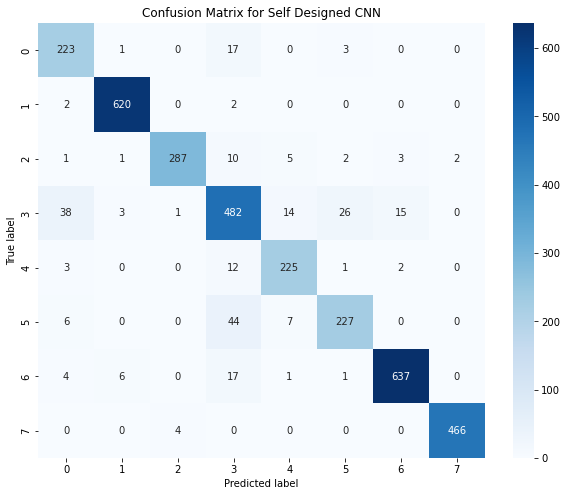

In [ ]:
y_pred = np.argmax(model_self.predict(X_test), axis=1)
Y_test=np.argmax(y_test,axis=1)

plot_cnf_matrix(Y_test,y_pred, "Confusion Matrix for Self Designed CNN")

In [ ]:
print_classification_report(Y_test,y_pred)


Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       244
           1       0.98      0.99      0.99       624
           2       0.98      0.92      0.95       311
           3       0.83      0.83      0.83       579
           4       0.89      0.93      0.91       243
           5       0.87      0.80      0.83       284
           6       0.97      0.96      0.96       666
           7       1.00      0.99      0.99       470

    accuracy                           0.93      3421
   macro avg       0.92      0.92      0.92      3421
weighted avg       0.93      0.93      0.93      3421



## 5.2. Evaluation for Self Designed CNN with augmented training data

107/107 [==============================] - 1s 5ms/step


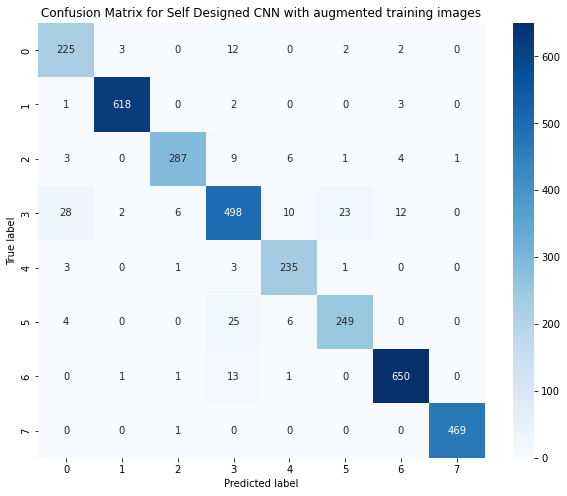

In [ ]:
y_pred = np.argmax(model_augmented.predict(X_test), axis=1)
Y_test=np.argmax(y_test,axis=1)

plot_cnf_matrix(Y_test,y_pred, "Confusion Matrix for Self Designed CNN with augmented training images")

In [ ]:
print_classification_report(Y_test,y_pred)


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       244
           1       0.99      0.99      0.99       624
           2       0.97      0.92      0.95       311
           3       0.89      0.86      0.87       579
           4       0.91      0.97      0.94       243
           5       0.90      0.88      0.89       284
           6       0.97      0.98      0.97       666
           7       1.00      1.00      1.00       470

    accuracy                           0.94      3421
   macro avg       0.93      0.94      0.94      3421
weighted avg       0.94      0.94      0.94      3421



## 5.3. Evaluation for Transfer Learning method


79/79 [==============================] - 9s 113ms/step


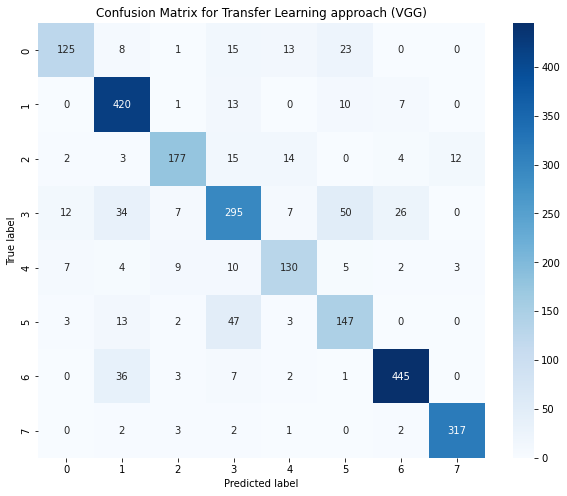


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.68      0.75       185
           1       0.81      0.93      0.87       451
           2       0.87      0.78      0.82       227
           3       0.73      0.68      0.71       431
           4       0.76      0.76      0.76       170
           5       0.62      0.68      0.65       215
           6       0.92      0.90      0.91       494
           7       0.95      0.97      0.96       327

    accuracy                           0.82      2500
   macro avg       0.81      0.80      0.80      2500
weighted avg       0.82      0.82      0.82      2500



In [30]:
y_pred_ = np.argmax(model_vgg.predict(X_test_), axis=1)
Y_test_=np.argmax(y_test_,axis=1)

plot_cnf_matrix(Y_test_,y_pred_, "Confusion Matrix for Transfer Learning approach (VGG)")

print_classification_report(Y_test_,y_pred_)

# 6. Saving the best model for production

Based on our evaluation results we can conclude that our "Self Designed Convolutional Neural Network with augmented training data" performs best with 94% accuracy on test set, and also better precision and recall scores across all classes.

In [ ]:
# # For google collab

# model_augmented.save('/content/drive/MyDrive/Project2/model_breast.h5')

# For saving in local directory

model_augmented.save('/home/yastaha/Desktop/Project2/model_blood.h5')

